In [1]:
!pip install nibabel

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from scipy.ndimage import gaussian_filter
import numpy as np
from skimage.transform import resize, rotate
from PIL import Image
import nibabel as nib

In [3]:
%matplotlib inline

In [4]:
test_img_path = "image_files/test_image/presentation_mri.jpg"

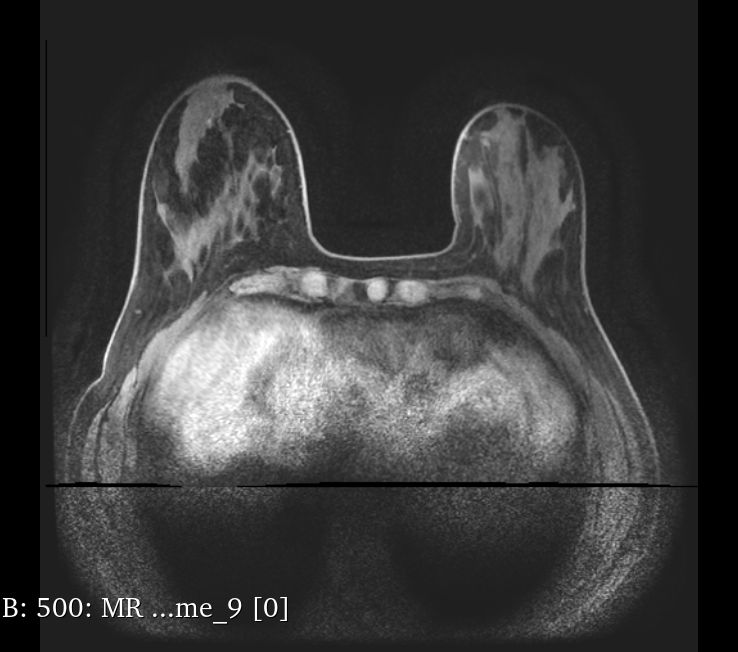

In [5]:
from PIL import Image
test_img = Image.open(test_img_path)
test_img.show()

# Rotation & blur

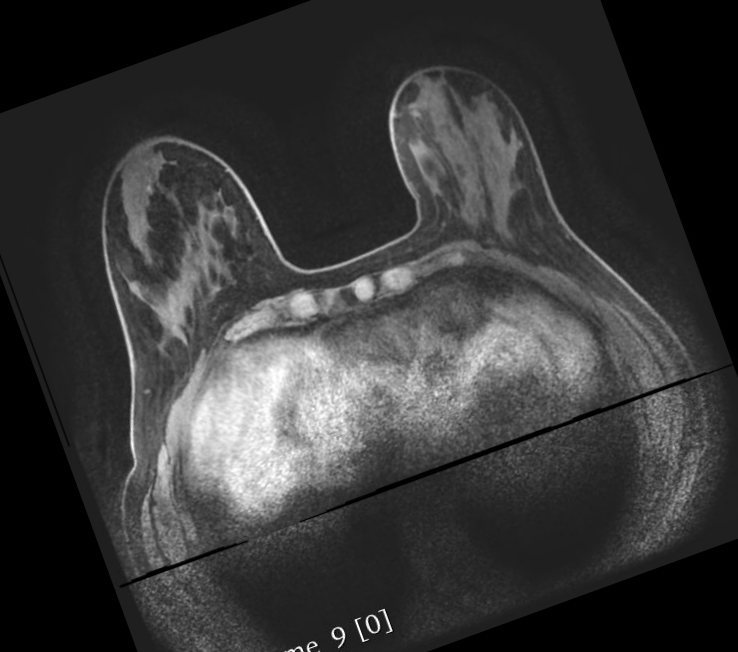

In [6]:
import skimage
import numpy as np

rotated_array = skimage.transform.rotate(np.array(test_img),20, preserve_range=True)
rotated_img = Image.fromarray(np.uint8(rotated_array))
rotated_img.show()

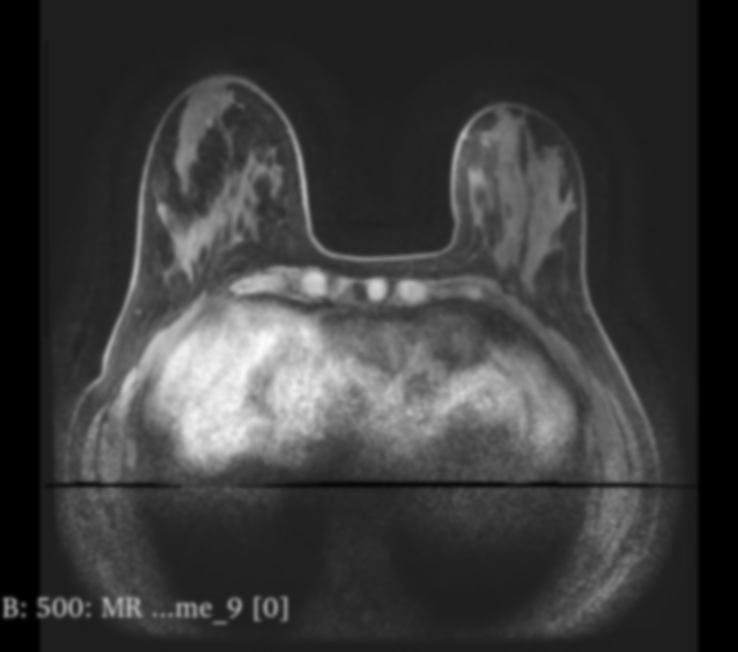

In [7]:
blurred_array = skimage.filters.gaussian(np.array(test_img),sigma=2,preserve_range=True)
blurred_img = Image.fromarray(np.uint8(blurred_array))
blurred_img.show()

# Generating augmented frames for 2D image

In [8]:
def imgage_path_to_array(image_path):
    if '.dcm' in image_path:
        dicom_data = pydicom.dcmread(image_path)
        return dicom_data.pixel_array
    elif '.nii.gz' in image_path:
        nifti_data = nib.load(image_path)
        return nifti_data.get_fdata()
    else:
        return np.array(Image.open(image_path))

In [9]:
def save_frame(frame, frame_number, save_frame_path, frame_name):
    frame_path = save_frame_path + f"{frame_name}_{frame_number:02d}.png"
    Image.fromarray((frame * 255).astype(np.uint8)).save(frame_path)
    img = plt.imread(frame_path)
    return img

In [10]:
def calculate_max_size(image_array, max_elongation):
    max_height = int(image_array.shape[0] * (1 + max_elongation))
    max_width = int(image_array.shape[1] * (1 + 0.25 * max_elongation))
    return max_height, max_width

In [11]:
def generate_random_factors(num_frames, random):
    if random:
        rnd_factors = {
            "rnd_me": np.random.rand() - 0.5,
            "rnd_ts": np.random.randint(0, int(num_frames * 0.15)) - int(num_frames * 0.15 * 0.5),
            "rnd_blur_size": (np.random.rand() - 0.5) * 2,
            "rnd_blur_shift": (np.random.rand() - 0.5) * np.pi
        }
    else:
        rnd_factors = {"rnd_me": 0, "rnd_ts": 0, "rnd_blur_size": 0, "rnd_blur_shift": 0}
    return rnd_factors

def apply_random_factors(max_elongation, blur_size, rnd_factors):
    max_elongation += rnd_factors["rnd_me"] * 0.015
    blur_size += rnd_factors["rnd_blur_size"]
    blur_shift = rnd_factors["rnd_blur_shift"]
    return max_elongation, blur_size, blur_shift

In [12]:
def generate_frame(image_array, frame_number, num_frames, max_elongation, blur_size, blur_shift, max_size):
    t = np.linspace(0, 2 * np.pi, num_frames)[frame_number]
    elongation_factor_height = 1.0 + max_elongation * np.sin(t)
    elongation_factor_width = 1.0 + max_elongation * np.sin(t) * 0.25
    output_image = resize(image_array, (int(image_array.shape[0] * elongation_factor_height),
                                        int(image_array.shape[1] * elongation_factor_width)),
                          anti_aliasing=True, mode='reflect')
    
    sigma = 0 + (blur_size * np.abs(np.sin(t + blur_shift)))
    output_image = gaussian_filter(output_image, sigma=(sigma, 0, 0))

    background = np.zeros((max_size[0], max_size[1], 3))
    top_offset = max_size[0] - output_image.shape[0]
    left_offset = int((max_size[1] - output_image.shape[1]) / 2)
    background[top_offset:top_offset + output_image.shape[0], left_offset:left_offset + output_image.shape[1]] = output_image[..., :3]
    return background

In [13]:
def generate_effect_frames_for_animation(image_path, save_frame_path,frame_name = "frame", num_frames=10, max_elongation=0.025, blur=True, random=False):
    
    # get array from img path
    image_array = imgage_path_to_array(image_path)

    blur_size = 3
    blur_shift = 0

    
    #generate random factor for amplitude, time scale, blur 
    rnd_factors = generate_random_factors(num_frames, random)
    max_elongation, blur_size, blur_shift = apply_random_factors(max_elongation, blur_size, rnd_factors)
    
    
    # Calculate the maximum elongation size of the output image (biggest elongations)
    max_height, max_width = calculate_max_size(image_array, max_elongation)
    max_size = (max_height, max_width)

    frames = []
    for frame_number in range(num_frames):
        background = generate_frame(image_array, frame_number, num_frames, max_elongation, blur_size, blur_shift, max_size)
        img = save_frame(background, frame_number, save_frame_path, frame_name)
        frames.append([img])

    return frames


# Save frames, and display as animation

In [14]:
def frames_to_animation():
    pass

In [15]:
num_frames = 10
test_img_path = "image_files/test_image/presentation_mri.jpg"
save_frame_path = "image_files/test_image/frames/" #needs '/' at the end; TODO: add fix in function
# test_img_path = "image_files/test_patient/p_001.nii.gz" #TODO: add .nii.gz compatibility
# save_frame_path = "image_files/test_patient/frames/" #needs '/' at the end TODO: add fix in function

frame_name = "frame"

# Generate frames with effects for animation
generate_effect_frames_for_animation(test_img_path,save_frame_path,frame_name,num_frames=num_frames)


# Set up the figure
fig = plt.figure()
ax = fig.add_subplot(111)
ax.axis('off')  # Turn off axes

# Load all the saved frames
frames = []  # To hold the images for animation
for i in range(0, num_frames):
    frame_path = save_frame_path+f"{frame_name}_{i:02d}.png"
    frame = Image.open(frame_path)
    frames.append([plt.imshow(frame, animated=True)])

# Create the animation
ani = animation.ArtistAnimation(fig, frames, interval=(2000/num_frames), blit=True, repeat_delay=1000)
ani.save('animation.gif', writer='pillow')
# Show the animation
plt.close()  # Close the static figure to prevent it from displaying
# ani  # This will show the animation in the output cell
%matplotlib inline
HTML(ani.to_jshtml())

# Generating augmented frames for 3D image

In [16]:
# test_img_path = "image_files/test_image/presentation_mri.jpg"
# save_frame_path = "image_files/test_image/frames/" #needs '/' at the end; TODO: add fix in function
# test_img_path = "image_files/test_patient/p_001.nii.gz" #TODO: add .nii.gz compatibility
# save_frame_path = "image_files/test_patient/frames/" #needs '/' at the end TODO: add fix in function

# frame_name = "frame"

# Generate frames with effects for animation
# frms =  generate_effect_frames_for_animation(test_img_path,save_frame_path,frame_name,num_frames=num_frames)

# mesh = vedo.Volume(test_img_path)
# vedo.show(mesh)

In [17]:
# np.shape(frms)

In [18]:
# import dicom2nifti
import nibabel as nib
import nilearn as nil
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
import os

In [19]:
def show_nifti_grid(path,rows,cols):
    nifti_vol = nib.load(path)
    nifti_vol_data = nifti_vol.get_fdata()

    n_subplots = rows * cols
    n_slice = nifti_vol_data.shape[2]
    print(np.shape(nifti_vol_data))
    step_size = n_slice // n_subplots
    plot_range = n_subplots * step_size
    start_stop = int((n_slice - plot_range) / 2)
    
    fig, axs = plt.subplots(rows, cols, figsize=[10, 10])
    
    for idx, img in enumerate(range(start_stop, plot_range, step_size)):
        axs.flat[idx].imshow(ndi.rotate(nifti_vol_data[:, :, img], 90), cmap='gray')
        axs.flat[idx].axis('off')
            
    plt.tight_layout(pad=-3.0)
    plt.show()

(512, 512, 116)


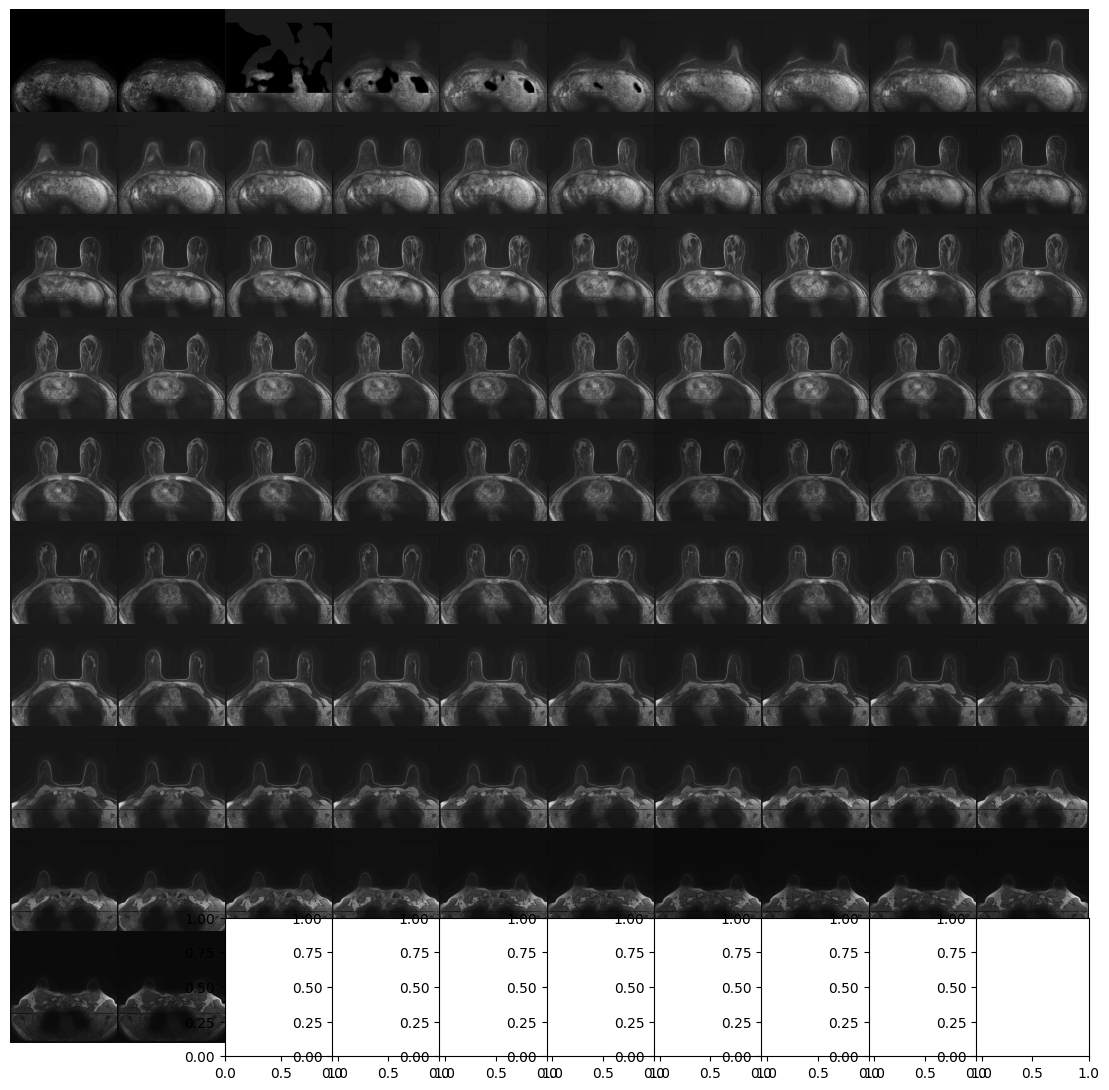

In [20]:
show_nifti_grid('image_files/test_patient/p_001.nii.gz',10,10)

In [21]:
import numpy as np
import nibabel as nib
from scipy.ndimage import zoom, gaussian_filter

def load_nifti(file_path):
    return nib.load(file_path)

def save_nifti(data, affine, header, file_path):
    new_img = nib.Nifti1Image(data, affine, header)
    new_img.to_filename(file_path)

def apply_transformations(image_data, factor_width, factor_height, blur_size, blur_shift, frame_number, num_frames):
    # Apply zoom transformation only to width and height, not depth
    transformed_data = zoom(image_data, (factor_width, factor_height, 1), order=1, mode='constant', cval=0)
    
    # Calculate the sigma for Gaussian blur
    t = np.linspace(0, 2 * np.pi, num_frames)[frame_number]
    sigma = 0 + (blur_size * np.abs(np.sin(t + blur_shift)))
    
    # Apply Gaussian blur
    transformed_data = gaussian_filter(transformed_data, sigma=(sigma*.25, sigma, 0))
    
    return transformed_data

def calculate_max_dimensions(data_shape, factors_width, factors_height):
    dimensions = [(int(np.ceil(data_shape[0] * fw)), 
                   int(np.ceil(data_shape[1] * fh)), 
                   data_shape[2]) for fw, fh in zip(factors_width, factors_height)]
    max_dims = np.max(dimensions, axis=0)
    return max_dims

def pad_to_max_dimensions(image_data, max_dims):
    # Ensure max_dims are at least as large as image_data dimensions
    if any(md < i_d for md, i_d in zip(max_dims, image_data.shape)):
        print(f"Error: max_dims {max_dims} must be greater than or equal to image_data dimensions {image_data.shape}.")
        raise ValueError("max_dims must be greater than or equal to image_data dimensions.")
     
    padded_data = np.zeros(max_dims, dtype=image_data.dtype)
    w_offset = (max_dims[0] - image_data.shape[0]) // 2
    h_offset = 0#(max_dims[1] - image_data.shape[1]) // 2
    d_offset = (max_dims[2] - image_data.shape[2]) // 2

    padded_data[w_offset:w_offset + image_data.shape[0],
                h_offset:h_offset + image_data.shape[1],
                d_offset:d_offset + image_data.shape[2]] = image_data
    return padded_data

def generate_transformed_niftis(input_path, output_path, num_files=5, max_elongation=0.1, blur_size=5, blur_shift=0.0):
    nifti_img = load_nifti(input_path)
    data = nifti_img.get_fdata()
    header = nifti_img.header
    affine = nifti_img.affine
    
    factors_width = 1.0 + max_elongation * np.sin(np.linspace(0, 2 * np.pi, num_files)) * 0.25
    factors_height = 1.0 + max_elongation * np.sin(np.linspace(0, 2 * np.pi, num_files))

    max_dims = calculate_max_dimensions(data.shape, factors_width, factors_height)
    print(max_dims)

    for i in range(num_files):
        factor_w = factors_width[i]
        factor_h = factors_height[i]
        transformed_data = apply_transformations(data, factor_w, factor_h, blur_size, blur_shift, i, num_files)  # Scale width, height, and apply Gaussian blur
        print(transformed_data.shape)
        padded_data = pad_to_max_dimensions(transformed_data, max_dims)
        save_nifti(padded_data, affine, header, f"{output_path}/transformed_{i}.nii.gz")

# # Example usage
# input_path = 'image_files/test_patient/p_001.nii.gz'
# output_path = 'image_files/test_patient/augmented_nifti_files/'
# generate_transformed_niftis(input_path, output_path)


In [22]:
num_files = 6

input_path = 'image_files/test_patient/p_001.nii.gz'
output_path = 'image_files/test_patient/augmented_nifti_files/'

generate_transformed_niftis(input_path, output_path, num_files)

[525 561 116]
(512, 512, 116)
(524, 561, 116)
(520, 542, 116)
(504, 482, 116)
(500, 463, 116)
(512, 512, 116)


(525, 561, 116)


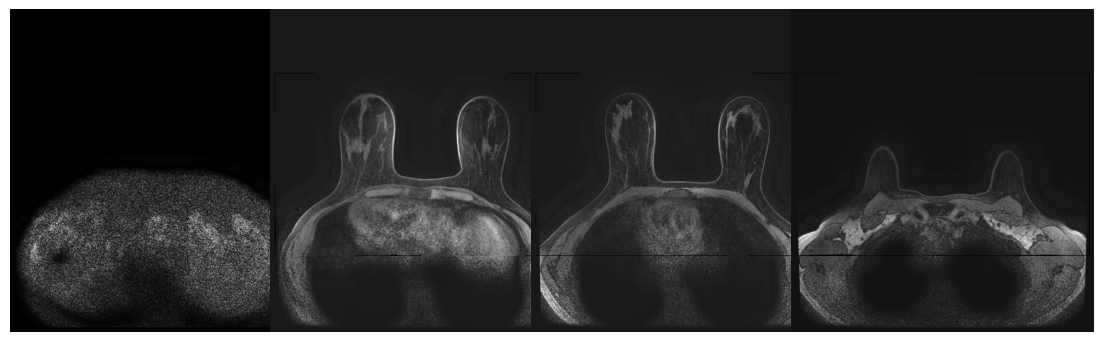

In [23]:
show_nifti_grid('image_files/test_patient/augmented_nifti_files/transformed_0.nii.gz',1,4)

(525, 561, 116)


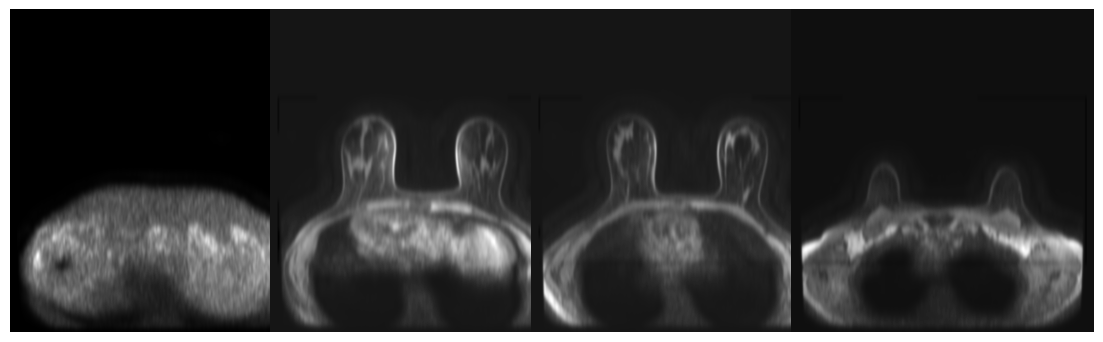

In [35]:
show_nifti_grid(f'image_files/test_patient/augmented_nifti_files/transformed_{num_files-2}.nii.gz',1,4)

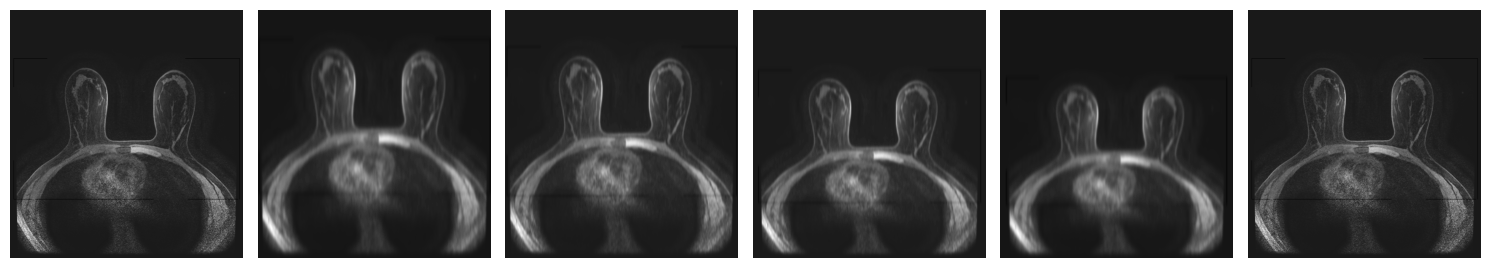

In [25]:
import nibabel as nib
import matplotlib.pyplot as plt

def display_slices(filenames, slice_index):
    """
    Display the same slice index for all given NIfTI files side by side.
    
    :param filenames: List of paths to the NIfTI files.
    :param slice_index: Index of the slice to display.
    """
    # Load all images
    images = [nib.load(filename) for filename in filenames]
    
    # Extract data from images
    slices = [img.get_fdata()[:, :, slice_index] for img in images]
    
    # Plot slices
    num_slices = len(slices)
    fig, axes = plt.subplots(1, num_slices, figsize=(15, 5))
    
    if num_slices == 1:
        axes = [axes]
        
    for i, slice_data in enumerate(slices):
        axes[i].imshow(slice_data.T, cmap="gray", origin="lower")
        # axes[i].set_title(f'Slice from {filenames[i]}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage
folder_path = 'image_files/test_patient/augmented_nifti_files/'
filenames = [folder_path+f'transformed_{i}.nii.gz' for i in range(num_files)]
slice_index = 50  # Adjust this index as needed
display_slices(filenames, slice_index)


## GPU EXPERIMENT (W.I.P.)

In [29]:
!pip install cupy cucim

Defaulting to user installation because normal site-packages is not writeable
  Using cached cupy-13.1.0.tar.gz (3.5 MB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [57 lines of output]
      Generating cache key from header files...
      Cache key (1527 files matching /tmp/pip-install-qy0c62p0/cupy_b4d435cf598a4086bc1f98b307e9d2a4/cupy/_core/include/**): 62825f3dfda8c42689c0b2e7570b111ea38841e7
      Clearing directory: /tmp/pip-install-qy0c62p0/cupy_b4d435cf598a4086bc1f98b307e9d2a4/cupy/.data
      
      -------- Configuring Module: cuda --------
      command 'gcc' failed: No such file or directory
      **************************************************
      *** WARNING: Cannot check compute capability
      command 'gcc' failed: No such file or directory
      **************************************************
      
      **************************************

In [30]:
!pip install cupy-cuda11x cucim

Defaulting to user installation because normal site-packages is not writeable


In [31]:
!python -m cupyx.tools.install_library --cuda 11.x --library cutensor

/home/jovyan/.local/lib/python3.11/site-packages/cupy/_environment.py:369: UserWarning: CuPy failed to preload library (/home/jovyan/.cupy/cuda_lib/11.x/cutensor/2.0.1/lib/libcutensor.so.2.0.1): OSError (libcublasLt.so.11: cannot open shared object file: No such file or directory)
  warnings.warn(msg)
Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/jovyan/.local/lib/python3.11/site-packages/cupyx/tools/install_library.py", line 300, in <module>
    main(sys.argv[1:])
  File "/home/jovyan/.local/lib/python3.11/site-packages/cupyx/tools/install_library.py", line 292, in main
    install_lib(params.cuda, params.prefix, params.library)
  File "/home/jovyan/.local/lib/python3.11/site-packages/cupyx/tools/install_library.py", line 193, in install_lib
    raise RuntimeError('''
RuntimeError: 
The destination directory /home/jovyan/.cupy/cuda_lib/11.x/cutensor/2.0.1 already exists.
Remove 

In [32]:
!export PATH=/usr/local/cuda-11.2/bin:$PATH
!export LD_LIBRARY_PATH=/usr/local/cuda-11.2/lib64:$LD_LIBRARY_PATH


In [33]:
import cupy as cp
import cucim.skimage.transform
import nibabel as nib

def load_nifti(file_path):
    nifti_img = nib.load(file_path)
    # Convert data to CuPy array for GPU processing
    return cp.asarray(nifti_img.get_fdata()), nifti_img.affine, nifti_img.header

def save_nifti(data, affine, header, file_path):
    # Convert CuPy array back to NumPy before saving
    new_img = nib.Nifti1Image(cp.asnumpy(data), affine, header)
    new_img.to_filename(file_path)

def apply_transformations(image_data, factor_width, factor_height):
    # Use CuCIM to rescale the image, similar to scipy's zoom but with GPU support
    transformed_data = cucim.skimage.transform.rescale(image_data, (factor_height, factor_width, 1), order=1, mode='constant', cval=0, anti_aliasing=False)
    return transformed_data

def calculate_max_dimensions(data_shape, factors_width, factors_height):
    dimensions = [(int(cp.ceil(data_shape[0] * fh)),
                   int(cp.ceil(data_shape[1] * fw)),
                   data_shape[2]) for fh, fw in zip(factors_height, factors_width)]
    max_dims = cp.max(cp.array(dimensions), axis=0)
    return max_dims

def pad_to_max_dimensions(image_data, max_dims):
    padded_data = cp.zeros(max_dims, dtype=image_data.dtype)
    h_offset = (max_dims[0] - image_data.shape[0]) // 2
    w_offset = (max_dims[1] - image_data.shape[1]) // 2
    d_offset = (max_dims[2] - image_data.shape[2]) // 2

    padded_data[h_offset:h_offset + image_data.shape[0],
                w_offset:w_offset + image_data.shape[1],
                d_offset:d_offset + image_data.shape[2]] = image_data
    return padded_data

def generate_transformed_niftis(input_path, output_path, num_files=5, max_elongation=0.1):
    data, affine, header = load_nifti(input_path)

    factors_width = cp.linspace(1., 1.+max_elongation, num_files)
    factors_height = cp.linspace(1., 1.+max_elongation*0.25, num_files)

    max_dims = calculate_max_dimensions(data.shape, factors_width, factors_height)

    for i in range(num_files):
        factor_w = factors_width[i]
        factor_h = factors_height[i]
        transformed_data = apply_transformations(data, factor_w, factor_h)  # Only scale width and height
        padded_data = pad_to_max_dimensions(transformed_data, max_dims)
        save_nifti(padded_data, affine, header, f"{output_path}/transformed_{i}.nii.gz")

# test_nifti_path = 'image_files/test_patient/p_001.nii.gz'
# save_nifti_path = 'image_files/test_patient/augmented_nifti_files/'

# generate_transformed_niftis(test_nifti_path, save_nifti_path)


/home/jovyan/.local/lib/python3.11/site-packages/cupy/_environment.py:369: UserWarning: CuPy failed to preload library (/home/jovyan/.cupy/cuda_lib/11.x/cutensor/2.0.1/lib/libcutensor.so.2.0.1): OSError (libcublasLt.so.11: cannot open shared object file: No such file or directory)
  warnings.warn(msg)


In [34]:
test_nifti_path = 'image_files/test_patient/p_001.nii.gz'
save_nifti_path = 'image_files/test_patient/augmented_nifti_files/'

generate_transformed_niftis(test_nifti_path, save_nifti_path)

RuntimeError: CuPy failed to load libnvrtc.so.11.2: OSError: libnvrtc.so.11.2: cannot open shared object file: No such file or directory

TESTING:

In [ ]:
import os
import nibabel as nib
import matplotlib.pyplot as plt
import imageio

def load_nifti_files(directory):
    """ Load all NIfTI files from the specified directory. """
    nifti_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.nii.gz')]
    nifti_files.sort()  # Ensure the files are in a predictable order
    return [nib.load(f) for f in nifti_files]

def extract_slice(nifti_images, slice_index=50):
    """ Extract the same slice from a list of NIfTI images. """
    slices = []
    for img in nifti_images:
        data = img.get_fdata()
        slices.append(data[:, :, slice_index])
    return slices

def create_gif(slices, output_path, duration=0.5):
    """ Create a GIF from a list of image slices. """
    images = [plt.imshow(slice, cmap='gray', animated=True) for slice in slices]
    imageio.mimsave(output_path, [img.get_array() for img in images], duration=duration)
    plt.close()

def visualize_nifti_transformations(directory, output_gif_path, slice_index=50):
    """ Load NIfTI files, extract slices, and create a GIF visualization. """
    nifti_images = load_nifti_files(directory)
    slices = extract_slice(nifti_images, slice_index)
    create_gif(slices, output_gif_path)

# Example usage:
visualize_nifti_transformations('image_files/test_patient/augmented_nifti_files', 'image_files/test_patient/gif/transformations.gif')



